# Análisis CIC-IDS-2018

## Introducción

En el siguiente *Notebook* se realiza un pequeño preprocesado del *dataset* CIC-IDS-2018 para los modelos basados en la detección de anomalías

## Librerías

In [1]:
import gc
from os import getcwd
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import gc
import tensorflow as tf

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

pd.set_option("display.max_columns", 80)

## Carga del conjunto de datos

In [2]:
df = pd.read_csv('../Data Preprocess/preprocessed-multiclass.csv', sep=',', low_memory=False)

num_cols = df.columns[:-3]
df

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,Down/Up Ratio,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Protocol_6,Protocol_17,Label
0,0,0.866025,-0.500000,112640768,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,1.385929e+02,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,0
1,0,0.866025,-0.500000,112641773,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,2.637508e+02,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,0
2,35605,0.866025,-0.500000,20784143,23,44,2416.0,240.0,64.0,105.043478,64.0,0.0,30.545455,3.149113e+05,1.145954e+06,9058214.0,20700000.0,4.823522e+05,1.396411e+06,9058214.0,41601.0,1,0,1.106613,2.116999,2900.003512,0,0,0,1,0,1.0,263,255,20,2624734.0,0.000000,9058214.0,1,0,0
3,0,0.866025,-0.500000,112640836,3,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,5.630000e+07,8.202439e+01,56300000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,0.026633,0.000000,0.000000,0,0,0,0,0,0.0,-1,-1,0,0.0,0.000000,56300000.0,0,0,0
4,23,0.866025,-0.500000,20,1,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,2.000000e+01,0.000000e+00,20.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,50000.000000,50000.000000,0.000000,0,0,1,0,0,1.0,58856,0,20,0.0,0.000000,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232938,50111,0.707107,-0.707107,22,3,0,31.0,31.0,0.0,10.333333,0.0,0.0,0.000000,1.100000e+01,1.555635e+01,22.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,136363.636364,0.000000,240.250000,0,0,0,1,0,0.0,64,-1,20,0.0,0.000000,0.0,1,0,0
16232939,443,0.707107,-0.707107,54682783,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.093656e+07,2.436610e+07,54523813.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.091436,0.018287,470.238095,0,0,0,1,0,0.0,256,180,20,158783.0,0.000000,54523813.0,1,0,0
16232940,443,0.707107,-0.707107,53682093,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.073642e+07,2.386193e+07,53421756.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.093141,0.018628,470.238095,0,0,0,1,0,0.0,254,180,20,259719.0,0.000000,53421756.0,1,0,0
16232941,443,0.707107,-0.707107,54683364,5,1,123.0,46.0,0.0,24.600000,46.0,46.0,46.000000,1.093667e+07,2.436586e+07,54523593.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,0,0.091435,0.018287,470.238095,0,0,0,1,0,0.0,254,180,20,158870.0,0.000000,54523593.0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16232943 entries, 0 to 16232942
Data columns (total 41 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   xhr                float64
 2   yhr                float64
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    float64
 7   Fwd Pkt Len Max    float64
 8   Fwd Pkt Len Min    float64
 9   Fwd Pkt Len Mean   float64
 10  Bwd Pkt Len Max    float64
 11  Bwd Pkt Len Min    float64
 12  Bwd Pkt Len Mean   float64
 13  Flow IAT Mean      float64
 14  Flow IAT Std       float64
 15  Flow IAT Max       float64
 16  Bwd IAT Tot        float64
 17  Bwd IAT Mean       float64
 18  Bwd IAT Std        float64
 19  Bwd IAT Max        float64
 20  Bwd IAT Min        float64
 21  Fwd PSH Flags      int64  
 22  Fwd URG Flags      int64  
 23  Fwd Pkts/s         float64
 24  Bwd Pkts/s         float64
 25  Pkt Len Var     

In [4]:
df.describe()

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,Down/Up Ratio,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Protocol_6,Protocol_17,Label
count,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07
mean,9.164073e+03,4.990946e-01,-3.485949e-02,1.181380e+07,2.353319e+01,6.312706e+00,9.730373e+02,2.007620e+02,1.107600e+01,5.031274e+01,3.501495e+02,2.647805e+01,1.130759e+02,3.335397e+06,1.275574e+06,6.602697e+06,7.597374e+06,8.241998e+05,8.511741e+05,2.612947e+06,2.912304e+05,4.389543e-02,1.638027e-04,3.667251e+04,1.531596e+04,4.117054e+04,4.795434e-03,1.873980e-01,3.920842e-01,3.316020e-01,4.171302e-02,4.964363e-01,8.787202e+03,8.689131e+03,1.799267e+01,1.728776e+05,8.644097e+04,4.685631e+06,7.269375e-01,2.583817e-01,1.052760e+00
std,1.892224e+04,2.622420e-01,8.251779e-01,4.940124e+08,1.521137e+03,1.640256e+02,6.216906e+04,3.035091e+02,2.422938e+01,6.050561e+01,4.974234e+02,5.097873e+01,1.641056e+02,2.229483e+08,3.381128e+08,6.595104e+08,2.586288e+07,4.340497e+06,3.376930e+06,1.024426e+07,3.825444e+06,2.048624e-01,1.279750e-02,2.133241e+05,9.241990e+04,2.129773e+05,6.908283e-02,3.902307e-01,4.882153e-01,4.707888e-01,1.999326e-01,9.967273e-01,1.623560e+04,2.061931e+04,7.693845e+00,2.505927e+06,1.514575e+06,6.365202e+07,4.455327e-01,4.377449e-01,2.603273e+00
min,0.000000e+00,1.224647e-16,-1.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.282200e+11,0.000000e+00,-8.282200e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.588190e-01,-8.660254e-01,4.920000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.220000e+02,0.000000e+00,3.930000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.548888e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.000000e-01,6.123234e-17,2.097000e+04,2.000000e+00,1.000000e+00,4.300000e+01,4.000000e+01,0.000000e+00,3.600000e+01,9.500000e+01,0.000000e+00,6.600000e+01,1.171400e+04,6.065311e+01,1.870000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.393169e+01,3.696231e+00,1.045333e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.800000e+02,-1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,3.389000e+03,7.071068e-01,8.660254e-01,3.002116e+06,5.000000e+00,4.000000e+00,4.560000e+02,3.080000e+02,2.900000e+01,6.740000e+01,4.880000e+02,4.800000e+01,1.625000e+02,2.187450e+05,2.457262e+05,1.070268e+06,5.510835e+05,1.643760e+0

Text(0.5, 1.0, 'Distribución del tráfico')

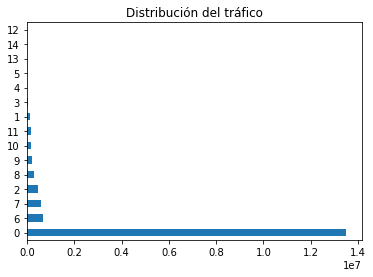

In [5]:
df['Label'].value_counts().plot(kind='barh')
plt.title('Distribución del tráfico')

In [6]:
df['Label'].value_counts()

0     13484708
6       686012
7       576191
2       461912
8       286191
9       193360
10      187589
11      161934
1       139890
3        41508
4        10990
5         1730
13         611
14         230
12          87
Name: Label, dtype: int64

## Tratamiento del conjunto

In [7]:
cols = ['Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Var', 'Down/Up Ratio', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Seg Size Min']

clf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, n_jobs=2, bootstrap = False, random_state=42)
clf.fit(df[num_cols])
pred = clf.predict(df[num_cols])

In [8]:
df['anomaly'] = pred
outliers = df.loc[df['anomaly']==-1]
outliers = outliers.loc[outliers['Label']<12]
outlier_index = list(outliers.index)
print(df['anomaly'].value_counts())
df.drop(['anomaly'], axis=1, inplace=True)

 1    14596711
-1     1636232
Name: anomaly, dtype: int64


In [9]:
df = df.iloc[df.index.difference(outlier_index)]
df.reset_index(drop=True, inplace = True)
df.describe()

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,Down/Up Ratio,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Protocol_6,Protocol_17,Label
count,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07
mean,9.518730e+03,4.963900e-01,-2.574498e-02,3.839155e+06,2.354006e+01,2.457894e+00,9.131224e+02,1.801780e+02,1.188422e+01,4.837461e+01,2.915150e+02,2.878306e+01,9.376931e+01,1.902409e+06,2.521132e+05,2.443918e+06,1.155953e+06,1.680320e+05,1.724325e+05,4.133611e+05,3.534282e+04,3.919470e-02,1.821594e-04,4.066341e+04,1.680965e+04,3.050906e+04,5.327427e-03,1.703621e-01,3.620142e-01,3.358283e-01,4.436942e-02,4.834389e-01,8.020020e+03,9.129303e+03,1.780637e+01,1.973713e+04,1.409396e+03,1.295198e+06,7.015154e-01,2.853078e-01,1.151827e+00
std,1.935259e+04,2.593562e-01,8.280511e-01,2.811629e+08,1.602439e+03,3.406954e+00,5.127831e+04,2.877259e+02,2.108795e+01,5.563460e+01,4.408349e+02,5.240396e+01,1.191503e+02,2.346191e+08,6.710023e+07,2.209917e+08,7.608973e+06,7.191070e+05,6.260418e+05,1.367986e+06,3.268491e+05,1.940579e-01,1.349542e-02,2.243477e+05,9.514646e+04,5.753103e+04,7.279455e-02,3.759506e-01,4.805829e-01,4.722792e-01,2.059145e-01,5.295627e-01,1.542939e+04,2.120703e+04,7.957533e+00,6.095996e+05,6.547092e+04,7.462327e+06,4.575932e-01,4.515610e-01,2.695378e+00
min,0.000000e+00,1.224647e-16,-1.000000e+00,-8.282200e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.282200e+11,0.000000e+00,-8.282200e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.588190e-01,-8.660254e-01,3.760000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.770000e+02,0.000000e+00,3.220000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.527601e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.000000e-01,2.588190e-01,1.070500e+04,2.000000e+00,1.000000e+00,4.100000e+01,3.900000e+01,0.000000e+00,3.500000e+01,7.900000e+01,0.000000e+00,6.100000e+01,3.600000e+03,0.000000e+00,9.920000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.371542e+02,5.777902e+00,6.750000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.780000e+02,-1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,3.389000e+03,7.071068e-01,8.660254e-01,1.376178e+06,4.000000e+00,4.000000e+00,3.260000e+02,1.610000e+02,3.200000e+01,6.022222e+01,3.200000e+02,5.600000e+01,1.390000e+02,1.311350e+05,1.012222e+05,9.431165e+05,5.931100e+04,2.251450e+0

In [10]:
df['Label'].value_counts()

0     11888700
6       686012
7       576161
2       451794
8       286168
9       193360
10      187589
11      142081
1       139890
3        39323
4         3367
5         1730
13         611
14         230
12          87
Name: Label, dtype: int64

In [11]:
num_cols = df.columns[:-3]
df[num_cols] = MinMaxScaler().fit_transform(df[num_cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [12]:
df

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,Down/Up Ratio,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Protocol_6,Protocol_17,Label
0,0.000000,0.866025,0.254333,0.999991,0.000006,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.999926,5.406509e-10,0.999926,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.438890e-09,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.551961,0,0,0
1,0.000000,0.866025,0.254333,0.999991,0.000006,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.999926,1.028892e-09,0.999926,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.438851e-09,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.551961,0,0,0
2,0.000000,0.866025,0.254333,0.999991,0.000006,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.999926,3.199770e-10,0.999926,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.438887e-09,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.551961,0,0,0
3,0.000351,0.866025,0.254333,0.999855,0.000000,0.000691,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.999858,0.000000e+00,0.999858,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,8.333333e-03,0.025000,0.000000,0.0,0.0,1.0,0.0,0.0,0.006757,0.898087,0.000015,0.357143,0.0,0.0,0.000000,1,0,0
4,0.000000,0.866025,0.254333,0.999991,0.000006,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.999926,2.206738e-11,0.999926,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.438874e-09,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.551961,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14597098,0.001221,0.707107,0.148985,0.999856,0.000006,0.002762,0.000016,0.079193,0.0,0.037257,0.121635,0.0,0.066158,0.999858,6.146874e-07,0.999858,0.003221,0.008549,0.018279,0.012878,0.000002,0.0,0.0,1.292872e-06,0.000005,0.017115,0.0,1.0,1.0,0.0,0.0,0.006757,0.125015,0.002289,0.357143,0.0,0.0,0.000000,1,0,0
14597099,0.001221,0.707107,0.148985,0.999856,0.000003,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.999858,0.000000e+00,0.999858,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,8.134883e-07,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.034164,0.000000,0.357143,0.0,0.0,0.000000,1,0,0
14597100,0.006760,0.707107,0.148985,0.999855,0.000006,0.000000,0.000008,0.022627,0.0,0.017819,0.000000,0.0,0.000000,0.999858,6.068530e-10,0.999858,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.953125e-03,0.000000,0.000266,0.0,0.0,0.0,1.0,0.0,0.000000,0.966049,0.000000,0.357143,0.0,0.0,0.000000,1,0,0
14597101,0.764782,0.707107,0.148985,0.999855,0.000006,0.000000,0.000003,0.015248,0.0,0.007174,0.000000,0.0,0.000000,0.999858,8.275269e-12,0.999858,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.666667e-01,0.000000,0.000136,0.0,0.0,0.0,1.0,0.0,0.000000,0.275742,0.000000,0.357143,0.0,0.0,0.000000,1,0,0


In [13]:
df.describe()

,Dst Port,xhr,yhr,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Var,FIN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,Down/Up Ratio,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Active Mean,Active Std,Idle Min,Protocol_6,Protocol_17,Label
count,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07,1.459710e+07
mean,1.452465e-01,4.963900e-01,4.955706e-01,9.998598e-01,7.279723e-05,1.697441e-03,9.215892e-05,8.862667e-02,1.904522e-02,3.358335e-02,7.266077e-02,2.108649e-02,5.084941e-02,9.998600e-01,9.834932e-07,9.998607e-01,9.632938e-03,1.114897e-02,1.413381e-02,1.377870e-02,2.345007e-03,3.919470e-02,1.821594e-04,6.777235e-03,8.404827e-03,1.728918e-02,5.327427e-03,1.703621e-01,3.620142e-01,3.358283e-01,4.436942e-02,3.266479e-03,1.223910e-01,1.393174e-01,3.179708e-01,1.731328e-04,5.579213e-05,1.269802e-02,7.015154e-01,2.853078e-01,1.151827e+00
std,2.953016e-01,2.593562e-01,4.212016e-01,3.394293e-04,5.175368e-03,2.352869e-03,5.175378e-03,1.415278e-01,3.379479e-02,3.862349e-02,1.098791e-01,3.839118e-02,6.461306e-02,2.832408e-04,2.617579e-04,2.667894e-04,6.340811e-02,4.771296e-02,5.131490e-02,4.559953e-02,2.168654e-02,1.940579e-01,1.349542e-02,3.739129e-02,4.757323e-02,3.260226e-02,7.279455e-02,3.759506e-01,4.805829e-01,4.722792e-01,2.059145e-01,3.578126e-03,2.354339e-01,3.235936e-01,1.420988e-01,5.347365e-03,2.591722e-03,7.316006e-02,4.575932e-01,4.515610e-01,2.695378e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.087282e-04,2.588190e-01,6.814835e-02,9.998551e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.998577e-01,0.000000e+00,9.998577e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.546002e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.428571e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.220722e-03,5.000000e-01,6.403187e-01,9.998551e-01,3.229682e-06,6.906077e-04,4.138017e-06,1.918347e-02,0.000000e+00,2.429823e-02,1.969093e-02,0.000000e+00,3.307921e-02,9.998577e-01,0.000000e+00,9.998577e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.952569e-05,2.888951e-06,3.825158e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.257202e-03,0.000000e+00,3.571429e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,5.171283e-02,7.071068e-01,9.491840e-01,9.998568e-01,9.689046e-06,2.762431e-03,3.290228e-05,7.919331e-02,5.128205e-02,4.180838e-02,7.976072e-02,4.102564e-02,7.537721e-02,9.998579e-01,3.948678e-07,9.998589e-01,4.942583e-04,1.493844e-03,4.619910e

In [14]:
import seaborn as sns

Text(0.5, 1.0, 'Correlación respecto a target')

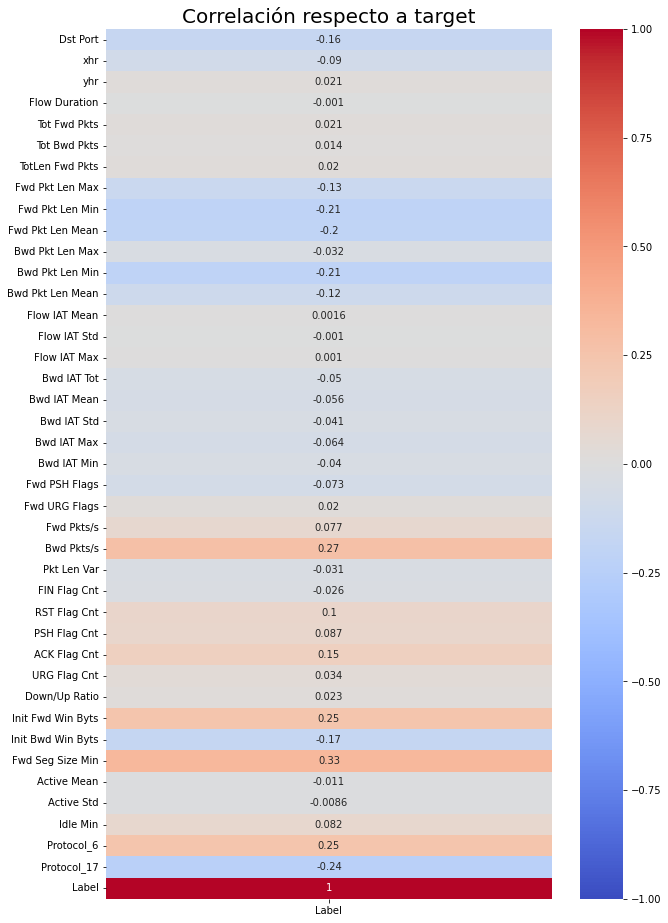

In [15]:
corr = df.corr()
# 
kot = corr
plt.figure(figsize=(10,16))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

Text(0.5, 1.0, 'Correlación DoS attack')

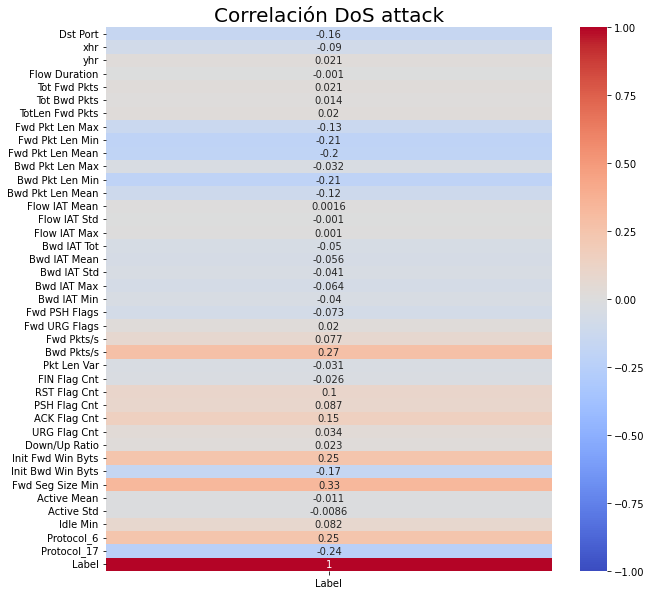

In [16]:
mask = (df['Label'] >= 0) | (df['Label'] <= 4)
d = df.loc[mask]
d.value_counts()
corr = d.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación DoS attack', fontsize=20)

Text(0.5, 1.0, 'Correlación DDoS+PortScan attack')

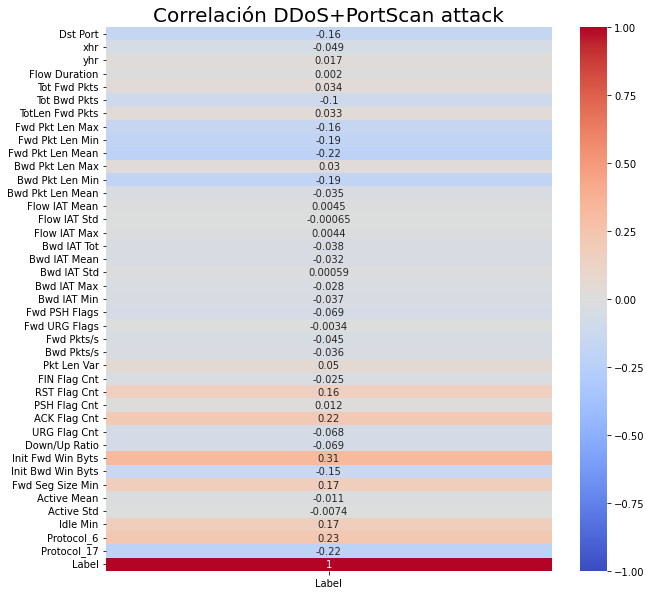

In [17]:
mask = (df['Label'] == 0) | ((df['Label'] > 4) & (df['Label'] <= 7)) 
d = df.loc[mask]
d.value_counts()
corr = d.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación DDoS+PortScan attack', fontsize=20)

Text(0.5, 1.0, 'Correlación Botnet attack')

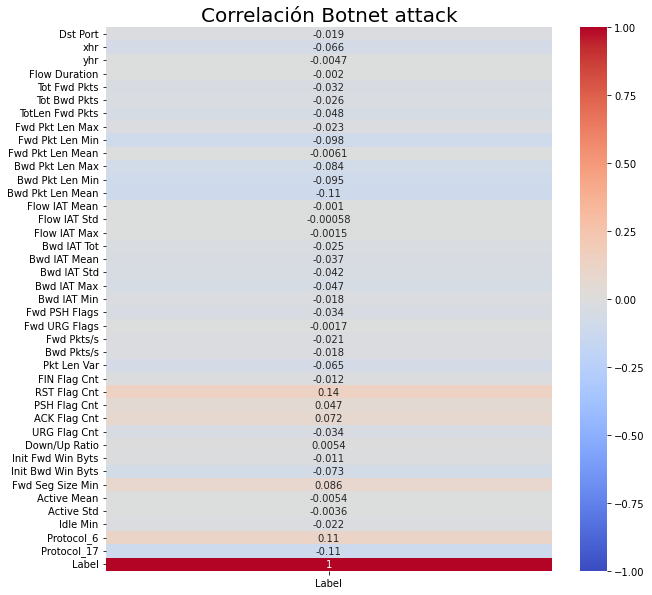

In [18]:
mask = (df['Label'] == 0) | (df['Label'] == 8)
d = df.loc[mask]
d.value_counts()
corr = d.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación Botnet attack', fontsize=20)

Text(0.5, 1.0, 'Correlación Bruteforce attack')

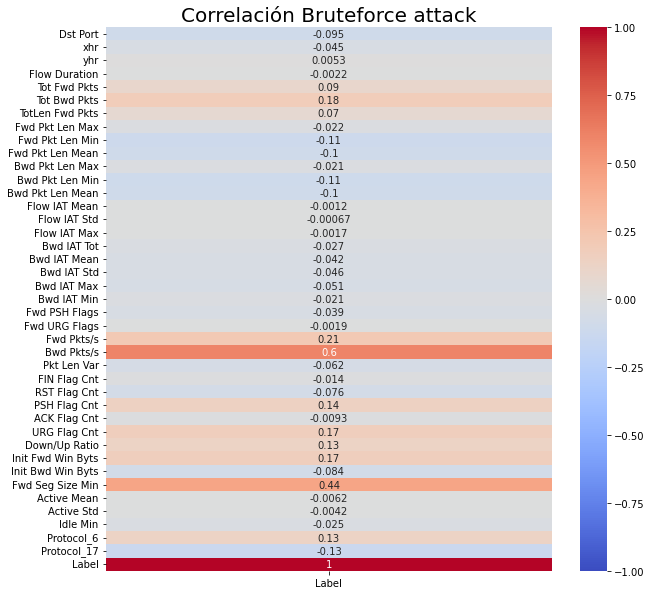

In [19]:
mask = (df['Label'] == 0) | ((df['Label'] > 8) & (df['Label'] <= 10)) 
d = df.loc[mask]
d.value_counts()
corr = d.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación Bruteforce attack', fontsize=20)

Text(0.5, 1.0, 'Correlación Infiltration attack')

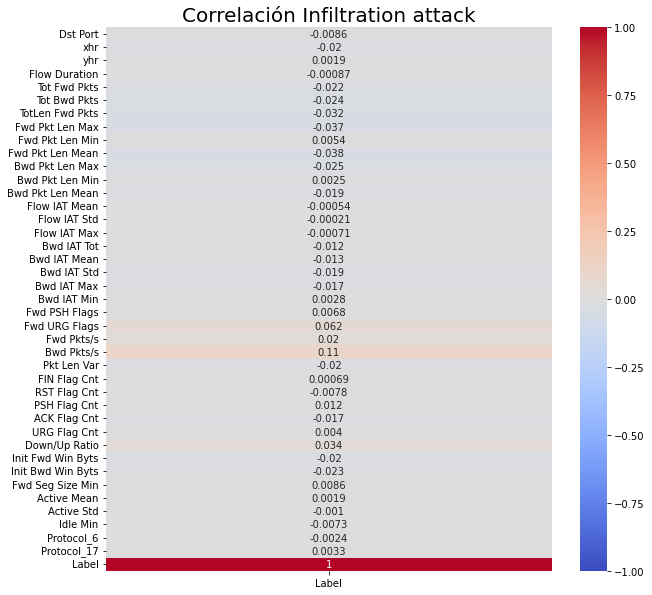

In [20]:
mask = (df['Label'] == 0) | (df['Label'] == 11)
d = df.loc[mask]
d.value_counts()
corr = d.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación Infiltration attack', fontsize=20)

Text(0.5, 1.0, 'Correlación Web attack')

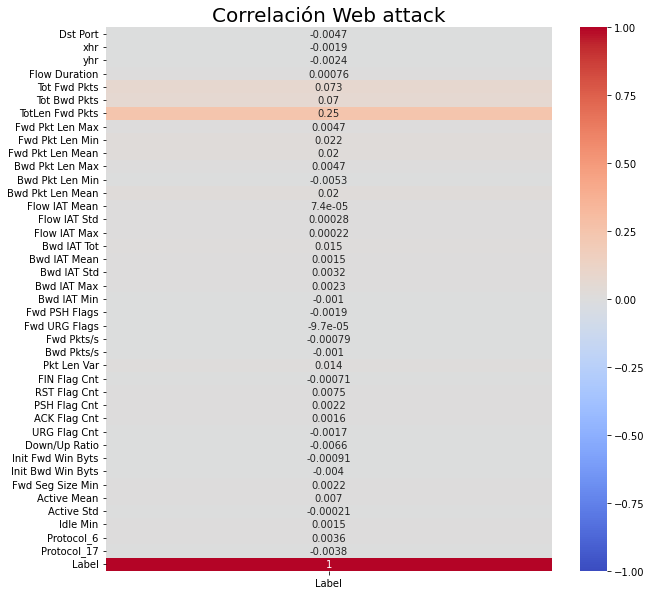

In [21]:
mask = (df['Label'] == 0) | (df['Label'] > 11)
d = df.loc[mask]
d.value_counts()
corr = d.corr()

kot = corr
plt.figure(figsize=(10,10))
#figure.tight_layout(pad=3.5, rect=[0, 0.03, 1, 0.95])
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación Web attack', fontsize=20)

Text(0.5, 1.0, 'Correlación respecto a target')

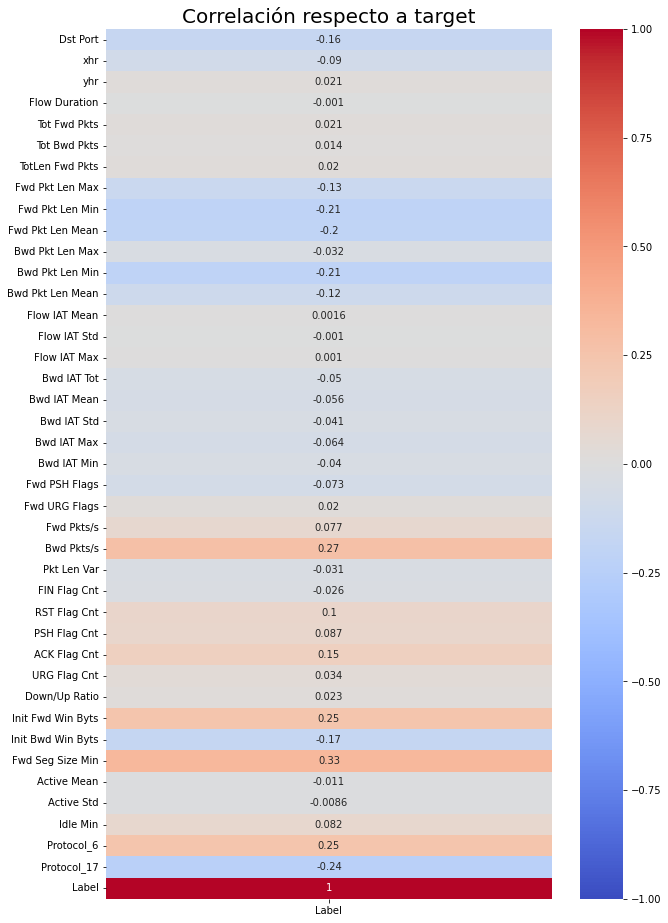

In [22]:
corr = df.corr()
# 
kot = corr
plt.figure(figsize=(10,16))
sns.heatmap(kot[['Label']], cmap='coolwarm', annot=True, vmin=-1).set_title('Correlación respecto a target', fontsize=20)

In [23]:
df.to_csv('AD-preprocesed.csv', index=False)